In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import os
import cv2
from PIL import Image
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-12-25 15:50:16.984805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 15:50:17.008198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 15:50:17.008229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 15:50:17.009131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 15:50:17.013655: I tensorflow/core/platform/cpu_feature_guar

##### Verstappen vs Leclerc

In [2]:
class preprocess:
    def __init__(self, path):
        self.path = path
        self.dir_list = os.listdir(path)
        self.img = np.empty((1,0))
        self.label = np.empty((1,0))
        self.target_size=None

        self.x_train = []
        self.y_train = []
        self.x_val = []
        self.y_val = []
        self.x_test = []
        self.y_test = []
        print(f"dir_list: {self.dir_list}")

    def show_shape(self):
        print(f"x_train shape: {self.x_train.shape}")
        print(f"x_val shape: {self.x_val.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"y_val shape: {self.y_val.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def load_data(self, targetsize):
        self.target_size =  targetsize

        for dir in self.dir_list:

            imgs_list = os.listdir(self.path+'/'+dir)
            img_num = len(imgs_list)
            print(img_num)

            for img in imgs_list:
                train_ratio = img_num * 0.7
                val_ratio = img_num * 0.23

                name = (re.findall('[a-z]+', img)[0])
                num = int(re.findall('\d+', img)[0])
                
                img_to_convert = Image.open(self.path+'/'+dir+'/'+img)
                img_array = np.array(img_to_convert)
                img_array = img_array[:,:,:3]
                img_array_resized = cv2.resize(img_array, self.target_size)

                # train set
                if 1 <= num <= train_ratio:
                    self.x_train.append(img_array_resized)
                    if name == "leclerc":
                        self.y_train.append(0)
                    elif name == "ver":
                        self.y_train.append(1)

                # train_validation set
                elif train_ratio <= num <= train_ratio+val_ratio:
                    self.x_val.append(img_array_resized)
                    if name == "leclerc":
                        self.y_val.append(0)
                    elif name == "ver":
                        self.y_val.append(1)

                # eval_validation set
                elif train_ratio+val_ratio <= num <= img_num:
                    self.x_test.append(img_array_resized)
                    if name == "leclerc":
                        self.y_test.append(0)
                    elif name == "ver":
                        self.y_test.append(1)

        # one-hot encoding
        self.y_train = tf.keras.utils.to_categorical(self.y_train, 2)
        self.y_val = tf.keras.utils.to_categorical(self.y_val, 2)
        self.y_test = tf.keras.utils.to_categorical(self.y_test, 2)

        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        self.x_val = np.array(self.x_val)
        self.y_val = np.array(self.y_val)     
        self.x_test = np.array(self.x_test)
        self.y_test = np.array(self.y_test)   

In [3]:
datasets = preprocess("./f1driver")

dir_list: ['verstappen', 'leclerc']


In [4]:
datasets.load_data((128, 128))

55
55


In [5]:
datasets.show_shape()

x_train shape: (76, 128, 128, 3)
x_val shape: (26, 128, 128, 3)
x_test shape: (8, 128, 128, 3)
y_train shape: (76, 2)
y_val shape: (26, 2)
y_test shape: (8, 2)


In [6]:
class CNN_Model:
    def __init__(self, batch_size, epochs, input_shape, optimizer, loss):
        self.model = Sequential()
        self.kernal = (3,3)
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.loss = loss
        self.hist = None
        self.res = None

    def First_Conv_layer(self,filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation, input_shape=self.input_shape))

    def Conv(self, filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation))

    def Pool(self, pool_size):
        self.model.add(MaxPooling2D(pool_size=pool_size))

    def Dense(self, filters, activation):
        self.model.add(Dense(filters, activation=activation))
        
    def Flatten(self):
        self.model.add(Flatten())

    def Dropout(self, ratio):
        self.model.add(Dropout(ratio))

    def compile(self):
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

    def fit(self, x_train, y_train, x_val, y_val, patience):
        timestamp = int(time.time())
        checkpoint=ModelCheckpoint(filepath=f'best_model_weights_{timestamp}.h5', save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)
        early_stopping = EarlyStopping( monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
        self.hist = self.model.fit(x_train, y_train, batch_size=self.batch_size, epochs=self.epochs, callbacks=[checkpoint, early_stopping], validation_data=(x_val, y_val), verbose=2)
    
    def evaluate(self, x_test, y_test):
        self.res = self.model.evaluate(x_test, y_test, verbose=0)
        print(f"acc of this model: {self.res[1]*100:.2f}%")
    

In [7]:
mymodel = CNN_Model(128, 90, datasets.x_train[0].shape, Adam(), 'categorical_crossentropy')

mymodel.First_Conv_layer(32, (3,3), 'relu')
mymodel.Conv(32, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Dropout(0.25)
mymodel.Conv(256, (3,3), 'relu')
mymodel.Conv(512, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Flatten()
mymodel.Dense(128, 'relu')
mymodel.Dropout(0.5)
mymodel.Dense(2, 'softmax')

2024-12-25 15:50:33.759867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-25 15:50:33.787301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-25 15:50:33.787510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
mymodel.compile()

In [9]:
mymodel.fit(datasets.x_train, datasets.y_train, datasets.x_val, datasets.y_val, 20)

Epoch 1/90


2024-12-25 15:50:36.403540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-25 15:50:36.488864: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-25 15:50:40.610539: I external/local_xla/xla/service/service.cc:168] XLA service 0x764ddcbf6340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-25 15:50:40.610558: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-25 15:50:40.615083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735109440.675526   18810 device_compiler.h:186] Compiled clust


Epoch 1: val_loss improved from inf to 4660.19336, saving model to best_model_weights_1735109436.h5
1/1 - 17s - loss: 6.6224 - accuracy: 0.5921 - val_loss: 4660.1934 - val_accuracy: 0.5000 - 17s/epoch - 17s/step
Epoch 2/90

Epoch 2: val_loss improved from 4660.19336 to 13.67652, saving model to best_model_weights_1735109436.h5
1/1 - 1s - loss: 7135.8296 - accuracy: 0.5000 - val_loss: 13.6765 - val_accuracy: 0.5000 - 580ms/epoch - 580ms/step
Epoch 3/90

Epoch 3: val_loss did not improve from 13.67652
1/1 - 0s - loss: 245.0799 - accuracy: 0.4211 - val_loss: 113.2905 - val_accuracy: 0.5000 - 269ms/epoch - 269ms/step
Epoch 4/90

Epoch 4: val_loss did not improve from 13.67652
1/1 - 0s - loss: 172.8394 - accuracy: 0.5000 - val_loss: 24.4570 - val_accuracy: 0.5000 - 268ms/epoch - 268ms/step
Epoch 5/90

Epoch 5: val_loss improved from 13.67652 to 2.09913, saving model to best_model_weights_1735109436.h5
1/1 - 1s - loss: 35.0146 - accuracy: 0.4605 - val_loss: 2.0991 - val_accuracy: 0.5000 - 5

In [10]:
mymodel.evaluate(datasets.x_val, datasets.y_val)

acc of this model: 76.92%


save weights

In [127]:
mymodel.model.load_weights("/home/ms/ws/git_ws/LearningModel/MyNote/CNN_Model/best_model_weights_1735108951.h5")

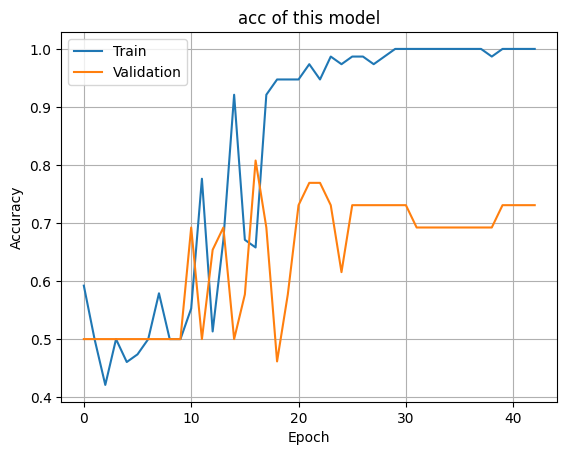

In [11]:
plt.plot(mymodel.hist.history['accuracy'])
plt.plot(mymodel.hist.history['val_accuracy'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("acc of this model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

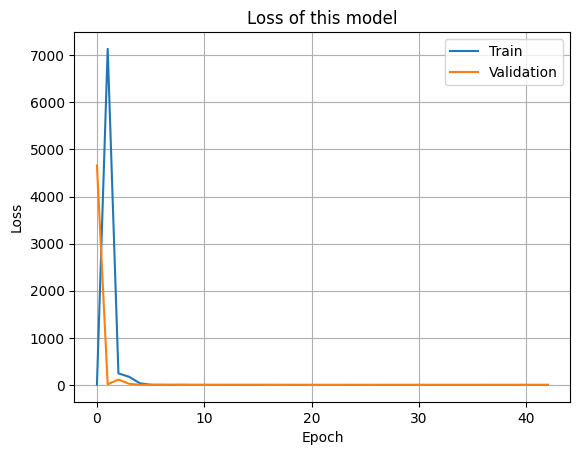

In [12]:
plt.plot(mymodel.hist.history['loss'])
plt.plot(mymodel.hist.history['val_loss'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("Loss of this model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [13]:
def img_into_numpy(path):
    test_list = []
    img_list = os.listdir(path)
    for imgs in img_list:
        img = Image.open(path+'/'+imgs)
        img_array = np.array(img)
        img_array = img_array[:,:,:3]

        img_array = cv2.resize(img_array, (128,128))
        test_list.append(img_array)

    test_list = np.array(test_list)
    print(f"shape of test_data: {test_list.shape}")

    return test_list


In [14]:
test_data = img_into_numpy("./f1driver_test")

shape of test_data: (8, 128, 128, 3)


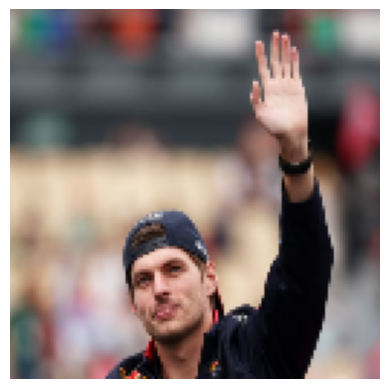

1/1 [==============================] - 0s 238ms/step
Predicted class: 1
It's Max Verstappen!


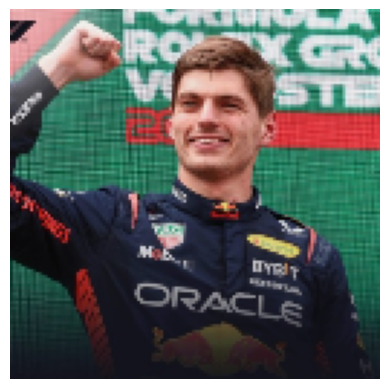

1/1 [==============================] - 0s 11ms/step
Predicted class: 1
It's Max Verstappen!


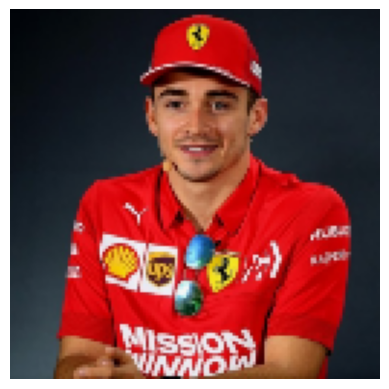

1/1 [==============================] - 0s 11ms/step
Predicted class: 0
It's Charles Leclerc!


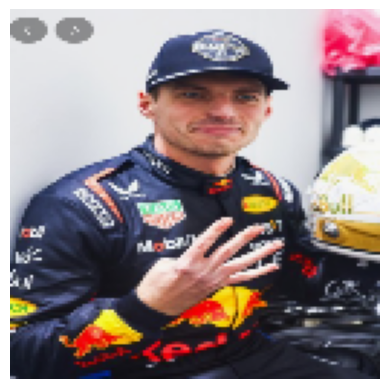

1/1 [==============================] - 0s 12ms/step
Predicted class: 1
It's Max Verstappen!


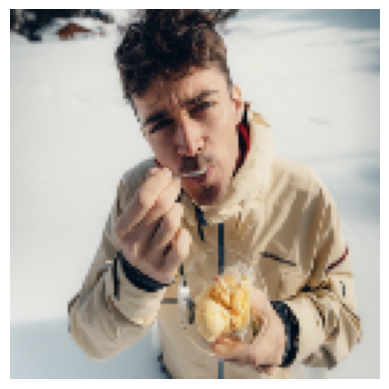

1/1 [==============================] - 0s 11ms/step
Predicted class: 0
It's Charles Leclerc!


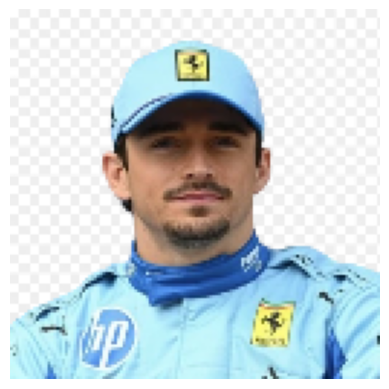

1/1 [==============================] - 0s 14ms/step
Predicted class: 0
It's Charles Leclerc!


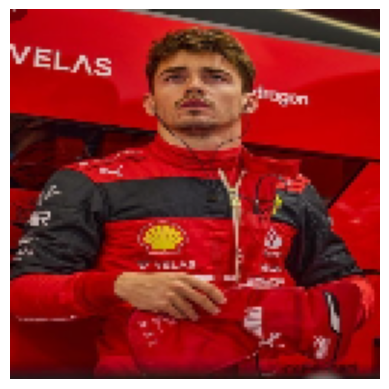

1/1 [==============================] - 0s 13ms/step
Predicted class: 0
It's Charles Leclerc!


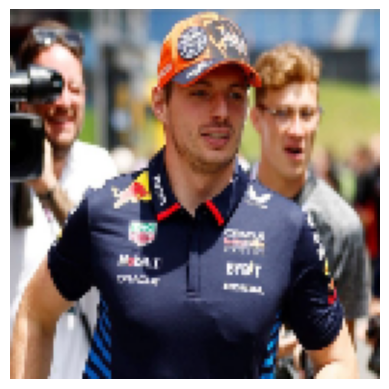

1/1 [==============================] - 0s 12ms/step
Predicted class: 1
It's Max Verstappen!


In [15]:
for each_data in test_data:
    plt.imshow(each_data)
    plt.axis("off")
    plt.show()
    
    # augment array_size (batch_size).
    each_data = np.expand_dims(each_data, axis=0)
    prediction = mymodel.model.predict(each_data)
    print("Predicted class:", prediction[0].argmax())
    if prediction[0].argmax() == 0:
        print("It's Charles Leclerc!")
    elif prediction[0].argmax() == 1:
        print("It's Max Verstappen!")


When you get an error like 'GPU EXHAUSTED'

In [22]:
from numba import cuda

device = cuda.get_current_device()
device.reset()